In [ ]:
!pip install mne

     |████████████████████████████████| 6.8MB 3.4MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

In [ ]:
import pandas as pd
from keras import optimizers, Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed

In [ ]:
from keras.layers import Input, BatchNormalization, RepeatVector, dot, Activation, multiply, concatenate, Flatten, Permute
from keras.models import Sequential, Model
from keras.layers import merge
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
from keras.layers import ConvLSTM2D, Conv3D, Multiply, Lambda

In [ ]:
from keras.utils.vis_utils import plot_model, model_to_dot

In [ ]:
from keras import backend as K

In [ ]:
SEED = 123
DATA_SPLIT_PCT = 0.2

In [ ]:
# bcieeg
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.5 MB, data loaded>

In [ ]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [ ]:
# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.5 MB, data loaded>

In [ ]:
# band-pass filter
# 0.5-70 Hz
raw.filter(0.5, 70., fir_design='firwin', skip_by_annotation='edge')

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 0.5 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 75.00 Hz)
- Filter length: 1057 samples (6.606 sec)



<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.5 MB, data loaded>

In [ ]:
raw.time_as_index

<bound method BaseRaw.time_as_index of <RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.5 MB, data loaded>>

In [ ]:
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

Used Annotations descriptions: ['T1', 'T2']


In [ ]:
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

In [ ]:
# extract epochs (events, channels, time steps)
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)

Not setting metadata
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Loading data for 45 events and 801 original time points ...
0 bad epochs dropped


In [ ]:
print(epochs)

<Epochs |  45 events (all good), -1 - 4 sec, baseline off, ~17.8 MB, data loaded,
 'feet': 24
 'hands': 21>


In [ ]:
epochs.get_data().shape # (epochs, channels, time steps)

(45, 64, 801)

In [ ]:
epochs_data = epochs['hands'].get_data()
print(epochs_data.shape)

(21, 64, 801)


In [ ]:
epochs.events # (, , event_id)

array([[  672,     0,     3],
       [ 2000,     0,     2],
       [ 3328,     0,     2],
       [ 4656,     0,     3],
       [ 5984,     0,     2],
       [ 7312,     0,     3],
       [ 8640,     0,     3],
       [ 9968,     0,     2],
       [11296,     0,     2],
       [12624,     0,     3],
       [13952,     0,     3],
       [15280,     0,     2],
       [16608,     0,     2],
       [17936,     0,     3],
       [19264,     0,     3],
       [20672,     0,     2],
       [22000,     0,     3],
       [23328,     0,     3],
       [24656,     0,     2],
       [25984,     0,     3],
       [27312,     0,     2],
       [28640,     0,     2],
       [29968,     0,     3],
       [31296,     0,     3],
       [32624,     0,     2],
       [33952,     0,     2],
       [35280,     0,     3],
       [36608,     0,     3],
       [37936,     0,     2],
       [39264,     0,     3],
       [40672,     0,     3],
       [42000,     0,     2],
       [43328,     0,     3],
       [44

In [ ]:
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2
# epochs_data = epochs.get_data()
# epochs_data_train = epochs_train.get_data()

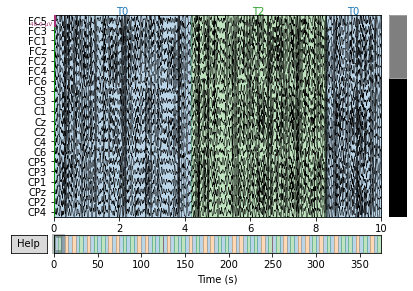

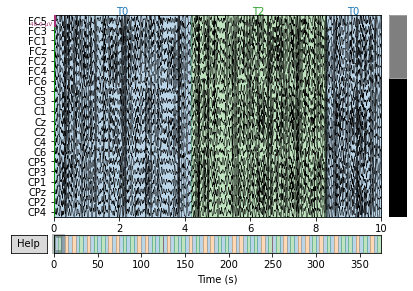

In [ ]:
raw.plot()

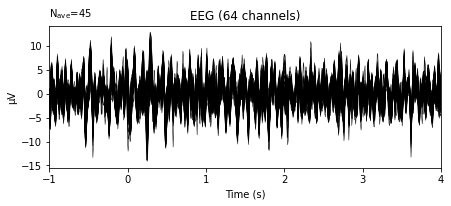

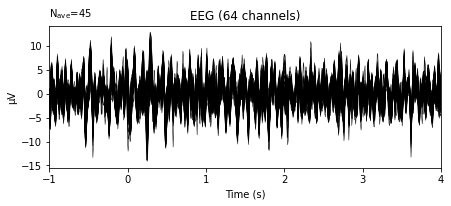

In [ ]:
evoked = epochs.average()
evoked.plot(time_unit='s')

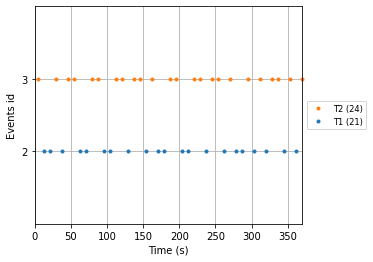

In [ ]:
event_dict=dict(T1=2, T2=3)
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_dict)

In [ ]:
events.shape

(45, 3)

In [ ]:
# mne.events_from_annotations

In [ ]:
raw.info['meas_date']

datetime.datetime(2009, 8, 12, 16, 15, tzinfo=datetime.timezone.utc)

In [ ]:
raw.annotations.orig_time

datetime.datetime(2009, 8, 12, 16, 15, tzinfo=datetime.timezone.utc)

In [ ]:
print(raw.annotations.onset)

[  0.    4.2   8.3  12.5  16.6  20.8  24.9  29.1  33.2  37.4  41.5  45.7
  49.8  54.   58.1  62.3  66.4  70.6  74.7  78.9  83.   87.2  91.3  95.5
  99.6 103.8 107.9 112.1 116.2 120.4 125.  125.  125.  129.2 133.3 137.5
 141.6 145.8 149.9 154.1 158.2 162.4 166.5 170.7 174.8 179.  183.1 187.3
 191.4 195.6 199.7 203.9 208.  212.2 216.3 220.5 224.6 228.8 232.9 237.1
 241.2 245.4 250.  250.  250.  254.2 258.3 262.5 266.6 270.8 274.9 279.1
 283.2 287.4 291.5 295.7 299.8 304.  308.1 312.3 316.4 320.6 324.7 328.9
 333.  337.2 341.3 345.5 349.6 353.8 357.9 362.1 366.2 370.4]


In [ ]:
raw

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.5 MB, data loaded>

In [ ]:
# segmentation
# augment epochs by overlapping->making multiple events
onset = [0, 40, 80]
duration = [80, 120, 160]
description = dict(T1=2, T2=3)
annots = mne.Annotations(onset, duration, description)
new_raw = raw.set_annotations(annots)

In [ ]:
onset = [0, 20, 40, 60, 80, 100, 120]
duration = [40, 60, 80, 100, 120, 140, 160]
description = dict(T1=2, T2=3)
annots = mne.Annotations(onset, duration, description)
new_raw = raw.set_annotations(annots)

In [ ]:
new_events, new_event_ids = mne.events_from_annotations(new_raw, chunk_duration=5)

Used Annotations descriptions: ["{'T1': 2, 'T2': 3}"]


In [ ]:
new_events.shape

(140, 3)

In [ ]:
new_event_ids

{"{'T1': 2, 'T2': 3}": 1}

In [ ]:
new_raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [ ]:
new_picks = pick_types(new_raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

In [ ]:
new_epochs = mne.Epochs(
    new_raw, new_events, tmin=tmin, tmax=tmax, baseline=None, proj=True, picks=new_picks, preload=True, event_repeated='drop')

Not setting metadata
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Loading data for 56 events and 801 original time points ...
1 bad epochs dropped


In [ ]:
new_epochs.get_data().shape

(55, 64, 801)

In [ ]:
new_epochs.events

array([[  800,     0,     1],
       [ 1600,     0,     1],
       [ 2400,     0,     1],
       [ 3200,     0,     1],
       [ 4000,     0,     1],
       [ 4800,     0,     1],
       [ 5600,     0,     1],
       [ 6400,     0,     1],
       [ 7200,     0,     1],
       [ 8000,     0,     1],
       [ 8800,     0,     1],
       [ 9600,     0,     1],
       [10400,     0,     1],
       [11200,     0,     1],
       [12000,     0,     1],
       [12800,     0,     1],
       [13600,     0,     1],
       [14400,     0,     1],
       [15200,     0,     1],
       [16000,     0,     1],
       [16800,     0,     1],
       [17600,     0,     1],
       [18400,     0,     1],
       [19200,     0,     1],
       [20000,     0,     1],
       [20800,     0,     1],
       [21600,     0,     1],
       [22400,     0,     1],
       [23200,     0,     1],
       [24000,     0,     1],
       [24800,     0,     1],
       [25600,     0,     1],
       [26400,     0,     1],
       [27

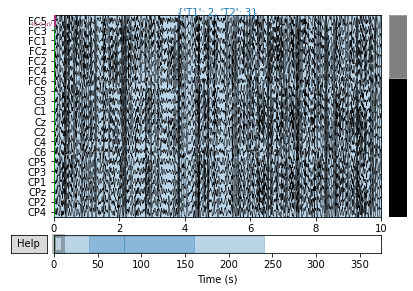

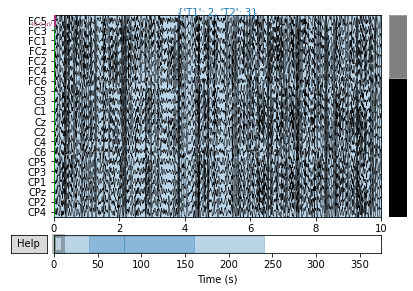

In [ ]:
new_raw.plot()

In [ ]:
new_epochs.get_data().shape

(55, 64, 801)

In [ ]:
X = new_epochs.get_data()

In [ ]:
X = np.transpose(X, (0, 2, 1))

In [ ]:
X.shape

(55, 801, 64)

In [ ]:
X_train, X_test = train_test_split(X, test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid = train_test_split(X_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

# DL Model

In [ ]:
# ConvLSTM + Attention (multiply)
# Hyper Parameters
N_EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-3 # learning rate
HIDDEN_SIZE = 256
# INPUT_SIZE = 125
OUTPUT_SIZE = 1
NUM_LAYERS = 4

In [ ]:
X.shape[1], X.shape[2]

(801, 64)

In [ ]:
# input_shape = (num_samples, timesteps, channels, rows, cols)

In [ ]:
model = Sequential()
model.add(Input(batch_shape=(None, BATCH_SIZE, 801, 64, 1))) # 801*64*1 frames
# how to choose num_conv_filters and kernel_size?
model.add(ConvLSTM2D(filters=801, kernel_size=(1, 64), padding="same", return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=64, kernel_size=(1, 64), padding="same", return_sequences=True))
model.add(BatchNormalization())

model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 801, 64, 801 23129676  
_________________________________________________________________
batch_normalization (BatchNo (None, None, 801, 64, 801 3204      
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 801, 64, 64) 1993216   
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 801, 64, 64) 256       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, None, 801, 64, 801 24946344  
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 801, 64, 801 3204      
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 801, 64, 64)

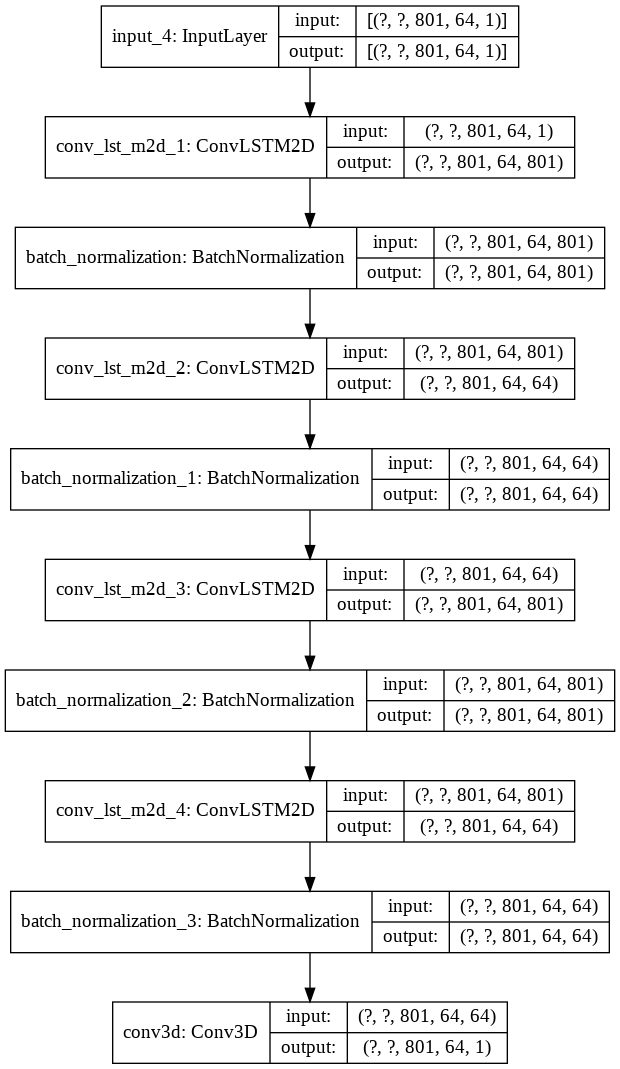

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
adam = optimizers.Adam(LR)

cp = ModelCheckpoint(filepath="/Users/zouhao/Desktop/EEGResearch/lstm_attention1_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/Users/zouhao/Desktop/EEGResearch/Attention1/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = model.fit(X_train, X_train, 
                                                epochs=N_EPOCHS, 
                                                batch_size=BATCH_SIZE, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
change = model.predict(X_train)
print(change.shape)

Epoch 1/10


ValueError: ignored

In [ ]:
X_train.shape

(35, 801, 64)

In [ ]:
# input_ = Input(shape=(X_train.shape[1], X_train.shape[2]))
# units = 35
# activations = LSTM(units, return_sequences=True)(input_)
input_ = Input(batch_shape=(None, BATCH_SIZE, 801, 64, 1))

In [ ]:
activations = ConvLSTM2D(filters=801, kernel_size=(1, 64), padding="same", return_sequences=True)(input_)

In [ ]:
attention = Dense(1, activation='tanh')(activations) 
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
# attention = RepeatVector(161)(attention)
attention = Permute([2, 1])(attention)

In [ ]:
# sent_representation = Merge([activations, attention], mode='mul')
sent_representation = Multiply()([activations, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units,))(sent_representation)

probabilities = Dense(3, activation='softmax')(sent_representation)

In [ ]:
model = Model(input_, probabilities)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 801, 64)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 801, 35)      14000       input_7[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 801, 1)       36          lstm[0][0]                       
__________________________________________________________________________________________________
flatten (Flatten)               (None, 801)          0           dense[0][0]                      
_______________________________________________________________________________________

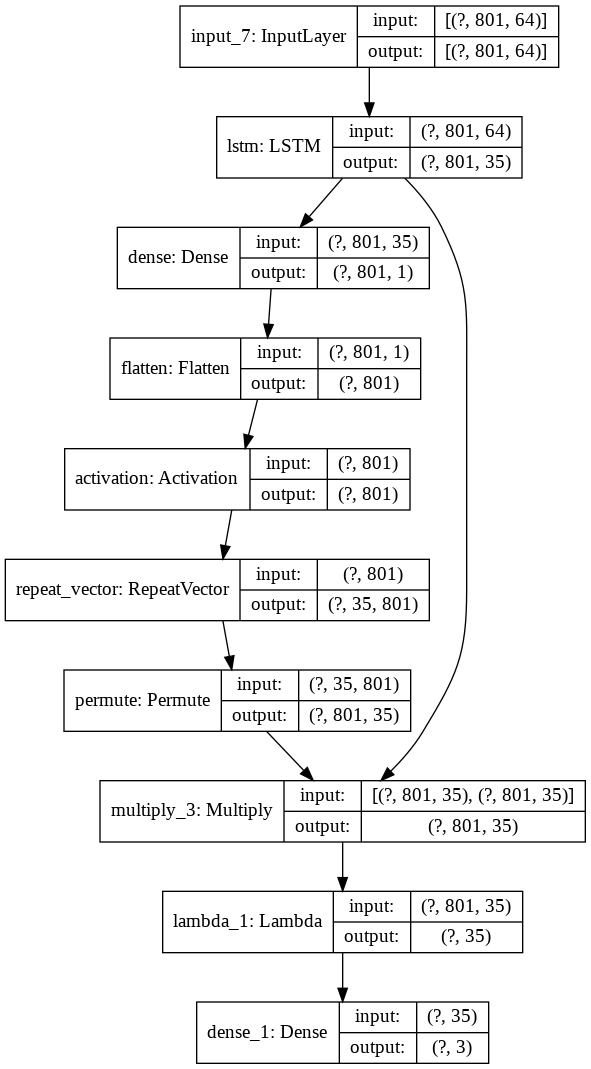

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
adam = optimizers.Adam(LR)

cp = ModelCheckpoint(filepath="/Users/zouhao/Desktop/EEGResearch/lstm_attention1_classifier.h5",
                               save_best_only=True,
                               verbose=0)
tb = TensorBoard(log_dir='/Users/zouhao/Desktop/EEGResearch/Attention1/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = model.fit(X_train, X_train, 
                                                epochs=N_EPOCHS, 
                                                batch_size=BATCH_SIZE, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
change = model.predict(X_train)
print(change.shape)

Epoch 1/10


ValueError: ignored